# Pytorch Lightning

PyTorch Lightning is the deep learning framework with “batteries included” for professional AI researchers and machine learning engineers who need maximal flexibility while super-charging performance at scale.

Lightning organizes PyTorch code to remove boilerplate and unlock scalability.

## Installing Pytorch Lightning

With pip:

```bash
pip install lightning
```

With conda:

```bash
conda install lightning -c conda-forge
```

In [1]:
!pip install lightning > /dev/null

## Basic imports

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, TensorDataset

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint

## XOR operator

The XOR gate/operator is also known as exclusive OR. It is from a digital logic gate. An XOR gate is a digital logic gate that produces a true output when it has dissimilar inputs.

In order to solve this problem, we need a fundamentally different kind of model that does not train on just input values but by conceptualizing I/O pairs and learning their relationship. That is the basis of the creation of NNs.

In order to solve the XOR, we will first solve the simpler AND gate.


### Preparing the data

Before we start preparing our inputs and target data for AND, it is important to understand that PyTorch Lightning accepts data loaders to train a model. Since PyTorch Lightning is built upon the PyTorch framework, all data that is being passed into the model must be in tensor form.

In [3]:
and_input = torch.Tensor([[0.,0.], [0.,1.], [1.,0.], [1., 1.]])
and_labels = torch.Tensor([[0.],[0.], [0.], [1.]])

Data loaders in PyTorch Lightning look for two main things—the key and the
value, which in our case are the features and target values. We are then using the
DataLoader module from torch.utils.data to wrap the xor_data and create a Python
iterable over the XOR data.

In [4]:
# TensorDataset: Dataset wrapping tensors.
# Each sample will be retrieved by indexing tensors along the first dimension.
and_data = TensorDataset(and_input, and_labels)

# Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = DataLoader(and_data, batch_size = 4, shuffle=True)

for data in train_loader.dataset:
    print(data)

(tensor([0., 0.]), tensor([0.]))
(tensor([0., 1.]), tensor([0.]))
(tensor([1., 0.]), tensor([0.]))
(tensor([1., 1.]), tensor([1.]))


### Configuring the model

Models in PyTorch Lightning
are built similarly to how they are built in PyTorch. One added advantage with PyTorch
Lightning is that it will make your code more structured with its life cycle methods; most
of the model training code is taken care of by the framework, which helps us avoid the
boilerplate code.

Every model we build using PyTorch Lightning must be inherited from a class called
LightningModule. This is a class that contains the boilerplate code, and this is
also where we have Lightning life cycle methods. In simple terms, we can say that
PyTorch LightningModule is the same as PyTorch nn.Module but with added
life cycle methods and other operations.

Any PyTorch Lightning model needs at least two life cycle methods—one for the training
loop to train the model (called training_step), and another to configure an optimizer
for the model (called configure_optimizers). In addition to these two life cycle
methods, we also use the forward method. This is where we take in the input data and
pass it to the model.

In [5]:
class ANDModel(L.LightningModule):
    """Defines a lightning model to solve the XOR problem

    Attributes:
        model: The stack of layers of the NN.
        history: A dictionary that contains training data, such as loss.
    """
    def __init__(self, model):
        """Initializes the XOR model

        Args:
            stack: The stack of layers of the NN.
        """
        super().__init__()
        self.model = model

        # The history dictionary will be used to store training information,
        # such as the loss or the accuracy of the models
        self.history = {
            'epochs': [],
            'loss': []
        }

    def forward(self, x):
        """Passes a tensor through the layers of a NN.

        The forward method acts as a mapper or medium where data is passed
        between multiple layers and the activation function.

        Args:
            x: Input tensor.
        """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """ Performs the training of the NN.

        Args:
            batch: Data that is being passed in the data loader is accessed
            in batches. This consists of two items: one is the input/features
            data, and the other item is targets.
            batch_idx: This is the index number or the sequence number
            for the batch of data.
        """
        x, y = batch
        y_hat = self.forward(x)

        # We are using the mean squared error loss function
        loss = nn.functional.mse_loss(y_hat, y)

        self.history['epochs'].append(self.current_epoch)
        self.history['loss'].append(loss.detach().numpy())

        if self.current_epoch % 100 == 0:
            print(f'epoch: {self.current_epoch} training_loss: {loss}')

        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        """ Defines the optimizer for the model
        """
        optimizer = optim.Adam(self.parameters(), lr = 1e-2)
        return optimizer


### Training the model

We first need to define the stack of layers that form the Neural network. In this case, we have the following layers:

- An input layer of 2 neurons.
- We use 2 hidden layers: one of 6 neurons, and another of 4 neurons.
- We use Sigmoid Activation between the hidden layers, and for the output layer.
- The 6 hidden layers are connected to a single output neuron.

All models built in PyTorch Lightning can be trained using a Trainer class. The Trainer class is an abstraction of some key things, such as looping over the dataset,
backpropagation, clearing gradients, and the optimizer step. All the boilerplate code from PyTorch is being taken by the Trainer class in PyTorch Lightning. Also, the Trainer
class supports many other functionalities that help us to build our model easily, and some of those functionalities are various callbacks, model checkpoints, early stopping,
dev runs for unit testing, support for GPUs and TPUs, loggers, logs, epochs, and many more.

In [6]:
and_layers= nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

and_model = ANDModel(and_layers)

# We use the ModelCheclpoint to save the model periodically.
checkpoint_callback = ModelCheckpoint()

trainer = L.Trainer(max_epochs = 1000, callbacks = [checkpoint_callback])

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Once the model trainer is ready, we invoke the fit method by passing model and input data;

In [7]:
trainer.fit(model=and_model, train_dataloaders=train_loader)

INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3      | train
---------------------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3      | train
---------------------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every

Training: |          | 0/? [00:00<?, ?it/s]

epoch: 0 training_loss: 0.20481669902801514
epoch: 100 training_loss: 0.1272815465927124
epoch: 200 training_loss: 0.08885674923658371
epoch: 300 training_loss: 0.06606195867061615
epoch: 400 training_loss: 0.05075249820947647
epoch: 500 training_loss: 0.03986307978630066
epoch: 600 training_loss: 0.031883418560028076
epoch: 700 training_loss: 0.025914901867508888
epoch: 800 training_loss: 0.021371811628341675
epoch: 900 training_loss: 0.01785709336400032


INFO: `Trainer.fit` stopped: `max_epochs=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


Once the model is trained, we can make predictions on it. In this case, we are using the same input data to make predictions.

In [8]:
'''
Context-manager that disables gradient calculation.

Disabling gradient calculation is useful for inference, when you are sure
that you will not call Tensor.backward(). It will reduce memory
consumption for computations that would otherwise have requires_grad=True.

In this mode, the result of every computation will have
requires_grad=False, even when the inputs have requires_grad=True.
'''
with torch.no_grad():
    test_output = and_model(and_input)
    for prediction in zip(and_input, torch.round(test_output)):
        print(f'Input Tensor: {prediction[0]} Prediction: {prediction[1]}')

Input Tensor: tensor([0., 0.]) Prediction: tensor([0.])
Input Tensor: tensor([0., 1.]) Prediction: tensor([0.])
Input Tensor: tensor([1., 0.]) Prediction: tensor([0.])
Input Tensor: tensor([1., 1.]) Prediction: tensor([1.])


We can also use the logs that are created each step to load the best model available. Identifying the latest version of a model can be done using checkpoint_callback.

Loading the model from the checkpoint can easily be done using the load_from_checkpoint method from the model object by passing the model checkpoint path:

In [9]:
!ls lightning_logs
print(checkpoint_callback.best_model_path)
trained_model = ANDModel.load_from_checkpoint(checkpoint_callback.best_model_path, model = and_layers)

version_0
/content/lightning_logs/version_0/checkpoints/epoch=999-step=1000.ckpt


We can the use a DataLoader to make predictions:

In [10]:
test_data = torch.utils.data.DataLoader(and_input, batch_size = 1)

with torch.no_grad():
    for tensor in test_data:
        prediction = trained_model(tensor)
        print(f'Input Tensor: {tensor} Prediciton: {prediction}')

Input Tensor: tensor([[0., 0.]]) Prediciton: tensor([[0.0045]])
Input Tensor: tensor([[0., 1.]]) Prediciton: tensor([[0.1411]])
Input Tensor: tensor([[1., 0.]]) Prediciton: tensor([[0.1413]])
Input Tensor: tensor([[1., 1.]]) Prediciton: tensor([[0.8568]])


Finally, we can use the history dictionary to plot the loss throughout the training epochs:

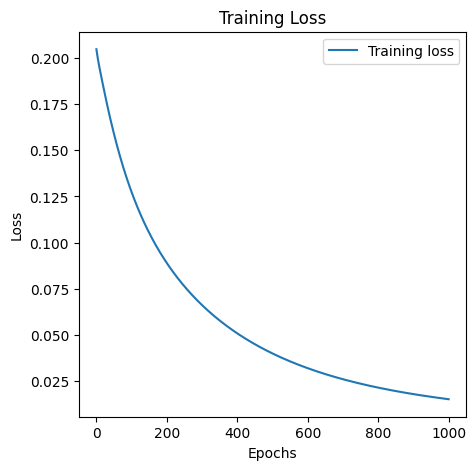

In [11]:
history_loss = and_model.history

epochs = history_loss['epochs']
loss = history_loss['loss']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(epochs, loss, label="Training loss")
ax.set_title("Training Loss")
ax.legend(loc='upper right')

# Challenge

Modify the code so that you can train an XOR model.

- Define the input data.
- Make the necessary changes to the class.
- Make the necessary changes to the model.

In [12]:
xor_input = torch.Tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
xor_labels = torch.Tensor([[0.], [1.], [1.], [0.]])

In [13]:
xor_data = TensorDataset(xor_input, xor_labels)
train_loader = DataLoader(xor_data, batch_size=4, shuffle=True)

In [14]:
xor_layers = nn.Sequential(
    nn.Linear(2, 2),  # Hidden layer with 2 neurons
    nn.ReLU(),        # Activation function
    nn.Linear(2, 1),  # Output layer
    nn.Sigmoid()      # Output activation
)

xor_model = ANDModel(xor_layers)  # Reuse ANDModel class

In [17]:
checkpoint_callback = ModelCheckpoint()
trainer = L.Trainer(max_epochs=1000, callbacks=[checkpoint_callback])
trainer.fit(model=xor_model, train_dataloaders=train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9      | train
---------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9      | train
---------------------------------------------
9         Trainable params
0         No

Training: |          | 0/? [00:00<?, ?it/s]

epoch: 0 training_loss: 0.0013429307145997882
epoch: 100 training_loss: 0.0002895502548199147
epoch: 200 training_loss: 0.00012186828826088458
epoch: 300 training_loss: 6.836162356194109e-05
epoch: 400 training_loss: 4.427652311278507e-05
epoch: 500 training_loss: 3.121510962955654e-05
epoch: 600 training_loss: 2.327354741282761e-05
epoch: 700 training_loss: 1.8069034922518767e-05
epoch: 800 training_loss: 1.44462128446321e-05
epoch: 900 training_loss: 1.1831302799691912e-05


INFO: `Trainer.fit` stopped: `max_epochs=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


In [18]:
with torch.no_grad():
    test_output = xor_model(xor_input)
    for prediction in zip(xor_input, torch.round(test_output)):
        print(f'Input Tensor: {prediction[0]} Prediction: {prediction[1]}')

Input Tensor: tensor([0., 0.]) Prediction: tensor([0.])
Input Tensor: tensor([0., 1.]) Prediction: tensor([1.])
Input Tensor: tensor([1., 0.]) Prediction: tensor([1.])
Input Tensor: tensor([1., 1.]) Prediction: tensor([0.])
